In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sent-with-data/INTC_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/MSFT_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/IBM_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/GS_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/BA_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/WMT_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/CSCO_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/KO_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/VZ_twitter_refined.csv


In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime
from sklearn import preprocessing

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from collections import defaultdict
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter

%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [14]:


def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print('Null Hypothesis: Unit Root Present')
    print('Test Statistic < Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    print (dfoutput, '\n')

def kpss_test(timeseries, regression='c'):
    # Whether stationary around constant 'c' or trend 'ct
    print ('Results of KPSS Test:')
    print('Null Hypothesis: Data is Stationary/Trend Stationary')
    print('Test Statistic > Critical Value => Reject Null')
    print('P-Value =< Alpha(.05) => Reject Null\n')
    kpsstest = kpss(timeseries, regression=regression)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output[f'Critical Value {key}'] = value
    print (kpss_output, '\n')



In [240]:
br = pd.read_csv('../input/twitter-sent-with-data/CSCO_twitter_refined.csv', parse_dates=['Date'],index_col='Date')

In [241]:
res_br = sm.tsa.seasonal_decompose(br.Close.dropna(),freq=365)
fig_br = res_br.plot()
fig_br.set_figheight(8)
fig_br.set_figwidth(15)
plt.show()

ValueError: x must have 2 complete cycles requires 730 observations. x only has 564 observation(s)

In [247]:
br.head()

,Close,Volume,sentiment
Date,,,
2012-08-17,19.059999,55706700.0,1.000000
2012-11-14,17.660000,97058200.0,0.000000
2012-11-15,17.940001,55885900.0,0.666667
2013-03-08,21.830000,23839100.0,0.000000
2013-03-19,21.520000,27264100.0,0.500000


In [246]:
br[br_split:]

,Close,Volume,sentiment
Date,,,
2019-08-02,53.250000,29021900.0,0.666667
2019-08-05,51.369999,29931800.0,0.250000
2019-08-06,52.599998,20708400.0,0.000000
2019-08-08,53.160000,26093500.0,0.000000
2019-08-09,52.430000,17425000.0,1.000000
...,...,...,...
2020-05-29,47.820000,43553600.0,0.000000
2020-06-01,46.299999,18712400.0,0.500000
2020-06-03,46.939999,17492000.0,1.000000


In [248]:
br_split = int(len(br)*0.8)
br_split_date = '2019-08-02'
br_split_date_next = '2019-08-05'
#br.iloc[br_split+1, 0:4]
tr_br_start,tr_br_end = '2012-08-17','2019-08-02'
te_br_start,te_br_end = '2019-08-05','2020-06-10'
tra_br = br['Close'][tr_br_start:tr_br_end].dropna()
tes_br = br['Close'][te_br_start:te_br_end].dropna()

train_start,train_end = tr_br_start,tr_br_end
test_start,test_end = te_br_start,te_br_end

In [249]:
#differentiate by moving average
movingAverage_BA = br['Close'].rolling(window=12).mean()
movingSTD_BA = br['Close'].rolling(window=12).std()
datasetLogScaleMinusMovingAverage = tra_br - movingAverage_BA
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

In [250]:
res_adf_br = sm.tsa.adfuller(br['Close'].dropna(),regression='ct')
print('p-value:{}'.format(res_adf_br[1]))
res_adf_br = sm.tsa.adfuller(br['Close'].diff().dropna(),regression='ct')
print('p-value:{}'.format(res_adf_br[1]))

res_adf_br = sm.tsa.adfuller(br['Close']['2013-01-01':].dropna(),regression='c')
print('p-value:{}'.format(res_adf_br[1]))
res_adf_br = sm.tsa.adfuller(br['Close']['2013-01-01':].diff().dropna(),regression='c')
print('p-value:{}'.format(res_adf_br[1]))

res_adf_br = sm.tsa.adfuller(br['Close']['2013-01-01':].dropna(),regression='ctt')
print('p-value:{}'.format(res_adf_br[1]))
res_adf_br = sm.tsa.adfuller(br['Close']['2013-01-01':].diff().dropna(),regression='ctt')
print('p-value:{}'.format(res_adf_br[1]))



p-value:0.6327857309428772
p-value:1.0369681616136421e-10
p-value:0.3213511896669732
p-value:1.756145753601036e-11
p-value:0.6199468379580804
p-value:1.9361862079118938e-09


In [251]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [252]:
kpss_test(br.Close)

Results of KPSS Test:
Null Hypothesis: Data is Stationary/Trend Stationary
Test Statistic > Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic          2.328246
p-value                 0.010000
Lags Used              19.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64 



In [253]:
sta_so2_df = pd.DataFrame(br.Close)
sta_so2_df['boxcox_SO_2'], lamda = boxcox(br.Close)
print('Box-Cox Lambda Value: ', lamda)

Box-Cox Lambda Value:  0.6771724318348018


In [254]:
tes_br

Date
2019-08-05    51.369999
2019-08-06    52.599998
2019-08-08    53.160000
2019-08-09    52.430000
2019-08-12    51.540001
                ...    
2020-05-29    47.820000
2020-06-01    46.299999
2020-06-03    46.939999
2020-06-05    47.830002
2020-06-10    47.419998
Name: Close, Length: 112, dtype: float64

Date
2019-08-05   -0.081173
2019-08-06   -0.054188
2019-08-08   -0.038756
2019-08-09   -0.045429
2019-08-12   -0.053257
2019-08-13   -0.023591
2019-08-14   -0.054193
2019-08-15   -0.127422
2019-08-16   -0.096820
2019-08-19   -0.053468
Name: Close, dtype: float64

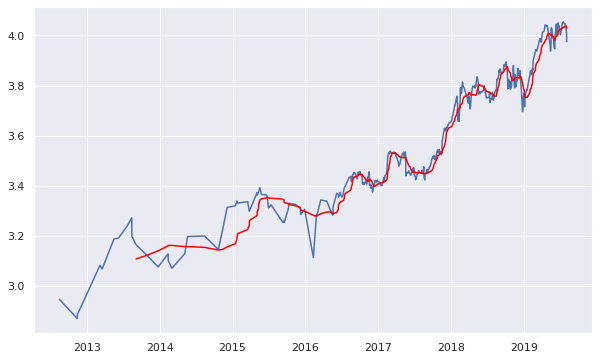

In [255]:
movingAverage = np.log(br.Close).rolling(window=12).mean()

indexedDataset_logScale_train = np.log(tra_br)
movingAverage_train = indexedDataset_logScale_train.rolling(window=12).mean()
movingSTD_train = indexedDataset_logScale_train.rolling(window=12).std()
plt.plot(indexedDataset_logScale_train)
plt.plot(movingAverage_train, color='red')
#datasetLogScaleMinusMovingAverage
LSMMA_train= indexedDataset_logScale_train - movingAverage

indexedDataset_logScale_test = np.log(tes_br)
movingAverage_test = indexedDataset_logScale_test.rolling(window=12).mean()
movingSTD_test = indexedDataset_logScale_test.rolling(window=12).std()
#datasetLogScaleMinusMovingAverage
LSMMA_test = indexedDataset_logScale_test - movingAverage


#Remove NAN values
LSMMA_train.dropna(inplace=True)
LSMMA_train.head(10)

LSMMA_test.dropna(inplace=True)
LSMMA_test.head(10)

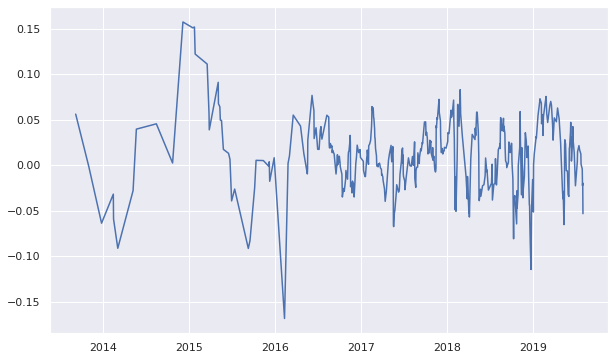

In [256]:
plt.plot(LSMMA_train)

In [257]:
kpss_test(LSMMA_train)


Results of KPSS Test:
Null Hypothesis: Data is Stationary/Trend Stationary
Test Statistic > Critical Value => Reject Null
P-Value =< Alpha(.05) => Reject Null

Test Statistic          0.044238
p-value                 0.100000
Lags Used              18.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64 



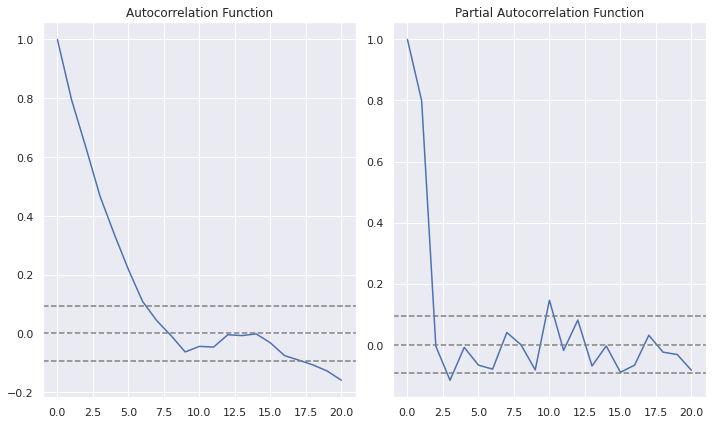

In [258]:
#ACF & PACF plots

lag_acf = acf(LSMMA_train, nlags=20)
lag_pacf = pacf(LSMMA_train, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(LSMMA_train)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(LSMMA_train)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(LSMMA_train)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(LSMMA_train)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()         

In [ ]:
resDiff_br = sm.tsa.arma_order_select_ic(LSMMA_train, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff_br['aic_min_order'],'is the best.')

In [223]:
type(LSMMA_train.reset_index(inplace=True, drop=True))

NoneType

In [224]:
LSMMA_train

0       0.071468
1       0.125435
2       0.053071
3       0.055704
4       0.036621
          ...   
1088   -0.050769
1089   -0.035485
1090   -0.032587
1091   -0.045574
1092   -0.109199
Name: Close, Length: 1093, dtype: float64

In [184]:
arima_br = sm.tsa.statespace.SARIMAX(LSMMA_train,order=(6, 1, 6),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima_br.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1093
Model:               SARIMAX(6, 1, 6)   Log Likelihood                2771.509
Date:                Thu, 20 May 2021   AIC                          -5517.019
Time:                        21:20:23   BIC                          -5452.157
Sample:                             0   HQIC                         -5492.465
                               - 1093                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3223      0.170     -1.894      0.058      -0.656       0.011
ar.L2          0.2258      0.207      1.091      0.275      -0.180       0.631
ar.L3         -0.0318      0.108     -0.294      0.769      -0.244       0.180
ar.L4         -0.0654      0.163     -0.402      0.688      -0.385       0.254
ar.L5          0.0085      0.112      0.076      0.939      -0.210       0.227
ar.L6          0.2515      0.113      2.220      0.026       0.029       0.474
ma.L1          0.1165      0.171      0.683      0.495      -0.218       0.451
ma.L2         -0.4839      0.209     -2.321      0.020      -0.893      -0.075
ma.L3         -0.0751      0.135     -0.556      0.578      -0.340       0.190
ma.L4          0.0416      0.173      0.240      0.810      -0.298       0.381
ma.L5         -0.1519      0.139     -1.093      0.274      -0.424       0.121
ma.L6         -0.4479      0.131     -3.421      0.001      -0.705      -0.191
sigma2         0.0004   2.23e-05     15.705      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.24   Jarque-Bera (JB):             32536.25
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

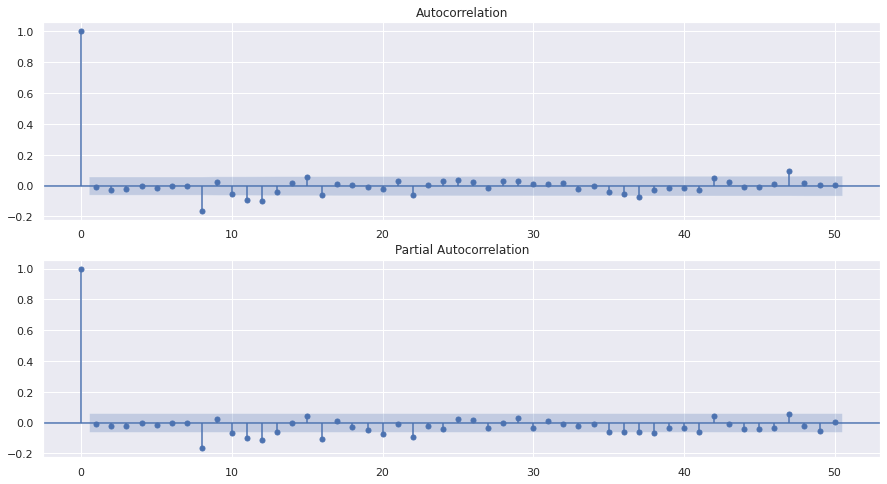

In [40]:
res_br = arima_br.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res_br, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res_br, lags=50, ax=ax[1])
plt.show()

In [185]:
pred_br = arima_br.forecast(275)
pred_br.shape
#print('ARIMA model MSE:{}'.format(mean_squared_error(LSMMA_test,pred_br)))

(275,)

In [189]:
pred_br.reset_index(inplace=True, drop=True)
LSMMA_test.reset_index(inplace=True, drop=True)

In [178]:
pred_br

0     -0.094323
1     -0.087398
2     -0.084200
3     -0.084539
4     -0.080270
         ...   
270   -0.078628
271   -0.078628
272   -0.078628
273   -0.078628
274   -0.078628
Name: predicted_mean, Length: 275, dtype: float64

In [172]:
LSMMA_test

NoneType

In [195]:
mse = mean_squared_error(LSMMA_test, pred_br)
print(f'{mse:.6f}')
mae = mean_absolute_error(LSMMA_test, pred_br)
print(f'{mae:.6f}')
rmse = math.sqrt(mean_squared_error(LSMMA_test, pred_br))
print(f'{rmse:.6f}')
mape = np.mean(np.abs(pred_br - LSMMA_test)/np.abs(pred_br))
print(f'{mape:.6f}')

0.000411
0.014383
0.020270
2.373870


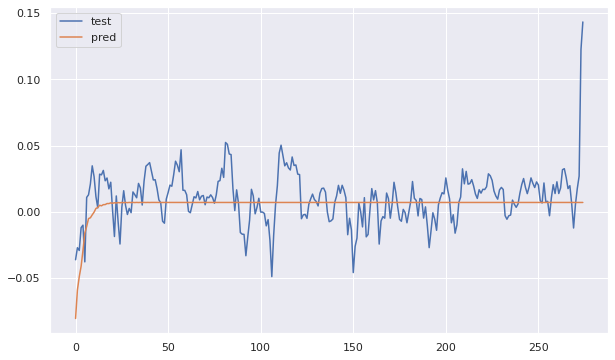

In [190]:
pd.DataFrame({'test':LSMMA_test,'pred':pred_br}).plot();plt.show()

In [225]:
tra_br_exog = br.copy()
sc = MinMaxScaler(feature_range=(0,1))
#time to split


#training_set_scaled = sc.fit_transform(tra_br_D)
tra_br_exog_index = tra_br_exog.index.values
tra_br_exog_volume = tra_br_exog.Volume.values
tra_br_exog_sentiment = tra_br_exog.sentiment.values
tra_br_exog_volume = sc.fit_transform(tra_br_exog_volume.reshape(-1, 1))
tra_br_exog_sentiment = sc.fit_transform(tra_br_exog_sentiment.reshape(-1, 1))
tra_br_exog[['Volume', 'sentiment']] = sc.fit_transform(tra_br_exog[['Volume', 'sentiment']])
tra_br_exog.dropna(inplace=True)
del tra_br_exog['Close']

br_exog = tra_br_exog.copy()

train_exog = br_exog[train_start:train_end].dropna()
test_exog = br_exog[test_start:test_end].dropna()
train_exog.reset_index(inplace=True, drop=True)
test_exog.reset_index(inplace=True, drop=True)

In [230]:
arima_br = sm.tsa.statespace.SARIMAX(LSMMA_train,order=(6, 1, 6),seasonal_order=(1,1,0,12),exog = train_exog,
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima_br.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1093
Model:             SARIMAX(6, 1, 6)x(1, 1, [], 12)   Log Likelihood                2595.797
Date:                             Thu, 20 May 2021   AIC                          -5159.595
Time:                                     21:46:49   BIC                          -5080.108
Sample:                                          0   HQIC                         -5129.473
                                            - 1093                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume         0.0080      0.010      0.833      0.405      -0.011       0.027
sentiment     -0.0019      0.001     -1.599      0.110      -0.004       0.000
ar.L1         -0.0100      0.179     -0.056      0.955      -0.361       0.341
ar.L2          0.0870      0.196      0.443      0.658      -0.298       0.472
ar.L3         -0.0613      0.176     -0.348      0.728      -0.406       0.283
ar.L4          0.1077      0.104      1.032      0.302      -0.097       0.312
ar.L5          0.1080      0.083      1.302      0.193      -0.055       0.271
ar.L6          0.0239      0.029      0.817      0.414      -0.033       0.081
ma.L1         -0.1361      0.213     -0.639      0.523      -0.553       0.281
ma.L2         -0.2223      0.226     -0.983      0.326      -0.666       0.221
ma.L3         -0.0254      0.206     -0.123      0.902      -0.430       0.379
ma.L4         -0.2287      0.152     -1.503      0.133      -0.527       0.070
ma.L5         -0.1917      0.122     -1.575      0.115      -0.430       0.047
ma.L6         -0.1951      0.047     -4.147      0.000      -0.287      -0.103
ar.S.L12      -0.4922      0.014    -34.035      0.000      -0.521      -0.464
sigma2         0.0004    5.6e-05      7.849      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              1985.38
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [234]:
pred_sarimax = arima_br.forecast(275, exog=test_exog)
pred_sarimax.shape
#print('ARIMA model MSE:{}'.format(mean_squared_error(LSMMA_test,pred_br)))

(275,)

In [236]:
pred_br.reset_index(inplace=True, drop=True)


In [239]:
mse = mean_squared_error(LSMMA_test, pred_sarimax)
print(f'{mse:.6f}')
mae = mean_absolute_error(LSMMA_test, pred_sarimax)
print(f'{mae:.6f}')
rmse = math.sqrt(mean_squared_error(LSMMA_test, pred_sarimax))
print(f'{rmse:.6f}')
mape = np.mean(np.abs(pred_sarimax - LSMMA_test)/np.abs(pred_sarimax))
print(f'{mape:.6f}')

0.004605
0.061690
0.067861
nan


In [235]:
pred_sarimax

1093   -0.081834
1094   -0.099749
1095   -0.093037
1096   -0.068517
1097   -0.054465
          ...   
1363   -0.048697
1364   -0.050751
1365   -0.042889
1366   -0.038656
1367   -0.042540
Name: predicted_mean, Length: 275, dtype: float64

In [229]:
train_exog

,Volume,sentiment
0,0.334334,0.000000
1,0.174733,1.000000
2,0.234245,0.000000
3,0.243013,1.000000
4,0.193218,0.000000
...,...,...
1088,0.066361,0.625000
1089,0.084132,0.500000
1090,0.087553,0.000000
1091,0.121104,0.666667


In [227]:
LSMMA_train

0       0.071468
1       0.125435
2       0.053071
3       0.055704
4       0.036621
          ...   
1088   -0.050769
1089   -0.035485
1090   -0.032587
1091   -0.045574
1092   -0.109199
Name: Close, Length: 1093, dtype: float64

In [216]:
train_exog = train_exog[:-2]

In [231]:
LSMMA_test

Date
2018-12-26   -0.036260
2018-12-27   -0.027169
2018-12-28   -0.029235
2018-12-31   -0.011980
2019-01-02   -0.010106
                ...   
2020-01-28    0.005432
2020-01-29    0.017514
2020-01-31    0.026989
2020-06-09    0.122678
2020-06-10    0.143470
Name: Close, Length: 275, dtype: float64